# Autocorrelated energy signature

In [an earlier tutorial](energysignature), we fitted a change-point model, function of outdoor air temperature, on the daily energy use data of a commercial building. It gave us an estimate of energy savings following an energy conservation measure, with uncertainty. However we saw that the autocorrelation of the model's prediction residuals was too high to trust this inference.

If a fitted model has autocorrelated residuals, then we have two options :

* If possible, improve the model itself with a better description of the building and its occupancy;
* If is it not possible to improve the model any further, because the data are insufficient to learn additional parameters, and autocorrelation remains, then we can somehow "include it" in the model.

The second option means that we will not "fix" the model, but let it aknowledge that it is missing something. Making reliable predictions will come at the cost of increased uncertainty.

## Moving average models

The original change-point model looked like:

```{math}
:label: acp1
y_t = f(x_t) + \varepsilon_t 
```

where $y_t$ are observed dependent data (energy use) and $f$ can be any function of some explanatory variables $x_t$ (outdoor temperature, occupancy, solar irradiance, etc.): linear, change-point, or other.

However, if we found after model fitting that residuals were correlated, then {eq}`acp1` no longer holds. Instead, the previous tutorial found a significant correlation between the consecutive errors $y_t - f(x_t)$ of the model:

```{math}
:label: acp2
y_t - f(x_t) = \theta_1 \varepsilon_{t-1} + \mathrm{normal}(0,\sigma^2) 
```

where $\theta_1$ is the lag-1 autocorrelation and the slope of the trend we saw on the last figure of [the change-point tutorial](energysignature).

The observational model is therefore:

```{math}
:label: acp3
y_t = f(x_t) + \theta_1 \varepsilon_{t-1} + \varepsilon_t
```

The last term of this equation are the errors of this new model, which we hope is are now independent no longer autocorrelated: $\varepsilon_t\sim N(0,\sigma^2)$.

In a more general form of this equation, we can even assume that residuals are correlated with their own previous values up to a higher lag $Q$:

```{math}
:label: acp4
y_t = f(x_t) + \theta_1 \varepsilon_{t-1} + \dots + \theta_Q \varepsilon_{t-Q} + \varepsilon_t
```

This is the formulation of a Moving Average (MA) model of order $Q$, $\mathrm{MA}(Q)$. It uses previous errors as predictors for future outcomes. Compared to the original model $f(x_t)$, this model has additional parameters $\left(\theta_1,...,\theta_Q\right)$. The Stan documentation has [a page on MA models](https://mc-stan.org/docs/stan-users-guide/moving-average-models.html), which we used as starting point for this tutorial.

## Data

This first block is just the same code as the beginning of [the change-point tutorial](energysignature), rewritten here as is.

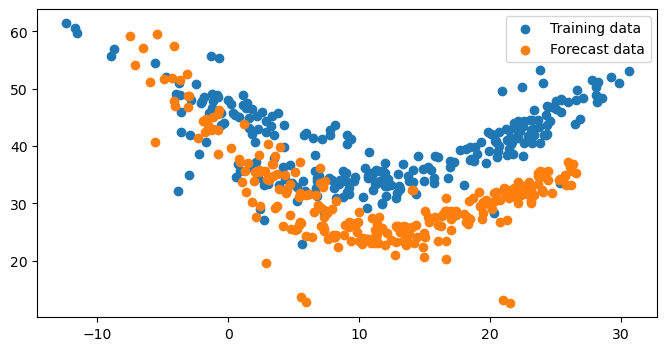

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import arviz as az
from cmdstanpy import CmdStanModel

def load_and_resample_data(file):
    df = pd.read_csv(file)
    df.set_index(pd.to_datetime(df["Date"]), inplace = True)
    df.drop("Date", axis=1, inplace=True)

    df['OAT'] = (df['OAT']-32)/1.8
    df['dayofweek'] = df.index.dayofweek
    df['weekend'] = (df['dayofweek'] == 5) | (df['dayofweek'] == 6)
    df = df.groupby(df.index.date).mean()

    return df

df1 = load_and_resample_data('data/building6pre.csv')
df2 = load_and_resample_data('data/building6during.csv')
df3 = load_and_resample_data('data/building6post.csv')

df_train = df1.loc[df1['weekend']==False]
df_test = df3.loc[df3['weekend']==False]

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(df_train['OAT'], df_train['Building 6 kW'], label='Training data')
ax.scatter(df_test['OAT'], df_test['Building 6 kW'], label='Forecast data')
ax.legend()

## Modelling and training


### Model specification

We will use the same change-point model, only modified to include a regression term for the previous error $\varepsilon_{n-1}$. This makes it a first order moving average model, $\mathrm{MA}(1)$:

```{math}
:label: acp5
y_n = \alpha + \beta_{h}(\tau_{h}-x_n)^+ + \beta_{c}(x_n-\tau_{c})^+ + \theta_1 \varepsilon_{n-1} + \varepsilon_n
```

```{math}
:label: acp6
\varepsilon_n \sim \mathrm{normal}\left(0, \sigma\right) 
```

The Stan code for this model is in a separate file `changepoint_101_ma1.stan`, and is more complicated than the original.

Firstly, there is a new block called `transformed parameters`, between `parameters` and `model`, which calculates the main terms of {eq}`acp5` so that the model itself is written concisely.

* `f` and `f_post` are the values of the change-point function itself, respectively during the pre and post periods.
* `epsilon` are the residuals according to {eq}`acp6`, calculated one after another.

```{code} stan
transformed parameters {
  vector[N] f;
  vector[N] epsilon;
  vector[N_post] f_post;
  for (n in 1:N) {
    f[n] = alpha + beta1 * fmax(tau1-x[n], 0) + beta2 * fmax(x[n]-tau2, 0);
  }
  epsilon[1] = y[1] - f[1];
  for (n in 2:N) {
    epsilon[n] = y[n] - f[n] - theta*epsilon[n-1];
  }
  for (n in 1:N_post) {
    f_post[n] = alpha + beta1 * fmax(tau1-x_post[n], 0) + beta2 * fmax(x_post[n]-tau2, 0);
  }
}
```

Then, the `model` reproduces {eq}`acp5`. Its formulation is quite tidy, since we defined each term in the previous block.

```{code} stan
model {
  // Priors not displayed
  for (n in 2:N) {
    y[n] ~ normal(f[n] + theta*epsilon[n-1], sigma);
  }
}
```

The block starts with the definition of some priors, which me omitted here although they belong in the model. Priors are important in a Bayesian workflow, and they are often the first way to regularise a model if convergence is difficult.

Finally, the `generated quantities` block is used again to generate predictions of energy use and savings with each iteration.

```{code} stan
generated quantities {
  y_hat[1] = normal_rng(f[1], sigma);
  log_lik[1] = normal_lpdf(y[1] | f[1], sigma)
  for (n in 2:N) {
    y_hat[n] = normal_rng(f[n] + theta*epsilon[n-1], sigma);
    log_lik[n] = normal_lpdf(y[n] | f[n] + theta*epsilon[n-1], sigma)
  }
  
  // Forecasts with increased uncertainty due to the autocorrelation
  y_hat_post[1] = normal_rng(f_post[1], sigma);
  savings += y_hat_post[1] - y_post[1];
  for (n in 2:N_post) {
    y_hat_post[n] = normal_rng(f_post[n], sigma * sqrt(1+theta^2));
    savings += y_hat_post[n] - y_post[n];
  }
}
```

The predictions of energy use during the baseline (pre) period $\tilde{y}$ account for previous residuals. However, a keen eye may have noticed a difference in the predictions of the post period $\tilde{y}_\mathit{post}$. Indeed, we do not know the value of residuals *after* the fitting period, since they are the difference between model predictions and the consumption of a hypothetical building *if it were identical to the pre-ECM building but in the post-ECM conditions*.

Therefore, [the muti-step prediction intervals of ARIMA models](https://otexts.com/fpp2/arima-forecasting.html) (which MA models are a subclass of) must account for an increased uncertainty $\hat{\sigma}_h$ formulated after the MA regression coefficients $\theta_i$:

```{math}
:label: acp7
\tilde{y}_\mathit{post} \sim \mathrm{normal}\left(f(x_\mathit{post}), \sigma_h^2 \right)
```

```{math}
:label: acp8
\hat{\sigma}_h = \hat{\sigma}^2 \left[1+\sum_{i=1}^{h-1}\hat{\theta}_i^2\right] 
```

We only have one $\theta_1$ coefficient in this $\mathrm{MA}(1)$ model, but {eq}`acp7` applies to a $\mathrm{MA}(Q)$ model where we may want to include regression coefficients with several past errors.

### Model fitting

The model is called by CmdStanPy

In [7]:
model = CmdStanModel(stan_file='models/changepoint_101_ma1.stan')

The model is called "changepoint_101_ma1" because it may have a slope on the low temperatures side (1), then a section of temperature-independent energy use (0), then a slope on the high temperatures side (1); then a MA(1) component is added to this change-point formulation.

The next step is the same as usual: defining a list which maps data to the Stan model, and calling the `sample()` command to fit the model.

In [8]:
model_data = {
    "N": len(df_train),
    "x": df_train['OAT'],
    "y": df_train['Building 6 kW'],
    "N_post": len(df_test),
    "x_post": df_test['OAT'],
    "y_post": df_test['Building 6 kW'],
    "alpha_prior": [35, 5], # baseline consumption at intermediate temperatures
    "beta1_prior": [2, 1], # low temperature slope
    "beta2_prior": [2, 1], # high temperature slope
    "tau1_prior": [8, 3], # low temperature break point
    "tau2_prior": [15, 3], # high temperature break point
    "theta_prior": [0.7, 0.1],
}

fit = model.sample(data=model_data, iter_warmup=3000, iter_sampling=4000, show_progress=False, show_console=False)

08:05:24 - cmdstanpy - INFO - CmdStan start processing
08:05:24 - cmdstanpy - INFO - Chain [1] start processing
08:05:24 - cmdstanpy - INFO - Chain [2] start processing
08:05:24 - cmdstanpy - INFO - Chain [3] start processing
08:05:24 - cmdstanpy - INFO - Chain [4] start processing


08:06:46 - cmdstanpy - INFO - Chain [1] done processing
08:07:07 - cmdstanpy - INFO - Chain [3] done processing
08:07:11 - cmdstanpy - INFO - Chain [4] done processing
08:07:32 - cmdstanpy - INFO - Chain [2] done processing
08:07:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in 'changepoint_101_ma1.stan', line 54, column 4 to column 52)
	Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in 'changepoint_101_ma1.stan', line 54, column 4 to column 52)
	Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in 'changepoint_101_ma1.stan', line 54, column 4 to column 52)
	Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in 'changepoint_101_ma1.stan', line 54, column 4 to column 52)
	Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in 'changepoint_101_ma1.stan', line 54, column 4 to column 52)
	Exception: normal_lpdf: L

We notice that convergence may be more difficult due to the added $\theta$ parameter: the model knows that something "more uncertain" is happening and some local optima may disturb the traces.

In [9]:
fs = fit.summary(percentiles=(5, 50, 95))
fs.loc[['alpha', 'beta1', 'beta2', 'tau1', 'tau2', 'theta', 'sigma', 'lp__']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,34.765000,0.005269,0.574424,33.799200,34.781000,35.704400,11883.40,51.3388,0.999927
beta1,1.402640,0.001427,0.134991,1.183310,1.401270,1.625720,8944.90,38.6437,0.999919
beta2,1.116530,0.001686,0.143756,0.903974,1.101730,1.374110,7269.31,31.4048,1.000250
tau1,6.250180,0.009425,0.849409,5.057040,6.128490,7.733550,8121.70,35.0873,1.000060
tau2,15.292700,0.013805,1.187910,13.503700,15.161300,17.333000,7404.52,31.9890,1.000140
theta,0.589476,0.000366,0.038167,0.525283,0.590165,0.650739,10883.30,47.0181,0.999916
sigma,3.250800,0.001374,0.147119,3.021500,3.243450,3.503290,11464.50,49.5289,0.999976
lp__,-434.306000,0.023227,1.836660,-437.819000,-433.975000,-431.949000,6252.67,27.0128,1.000140


Remember that we need to validate our [inference diagnostics](workflow_step2) criteria! All traces must match, `n_eff` should be in the thousands and `Rhat` exactly 1 for all parameters.

Since all convergence diagnostics are fine, we can save results into an ArviZ InferenceData object which will facilitate further analysis.

In [10]:
idata = az.from_cmdstanpy(
    posterior = fit,
    posterior_predictive="y_hat",
    observed_data={"y": df1['Building 6 kW'].values},
    constant_data={"x": df1[['OAT']].values},
    log_likelihood="log_lik",
    dims={
        "y_hat": ["observations"],
        "log_lik": ["observations"],
        "y": ["observations"],
        "y_hat_post": ["forecast"]
        },
)

## Posterior predictions

In the `generated quantities` block of the Stan code, we defined two posterior predictive quantities:

* `y_hat` are predictions by the trained model within the baseline period. All samples of `y_hat` form the posterior predictive distribution within the training set: $p\left(\hat{y}_\mathit{base}|x_\mathit{base}, y_\mathit{base}\right)$
* `y_hat_post` are predictions over the "post" dataset. All samples form the posterior predictive distribution of the reporting period: $p\left(\hat{y}_\mathit{repo}|x_\mathit{repo}, x_\mathit{base}, y_\mathit{base}\right)$

The following block displays both, compared to their respective dataset.

Text(0, 0.5, 'Building 6 kW')

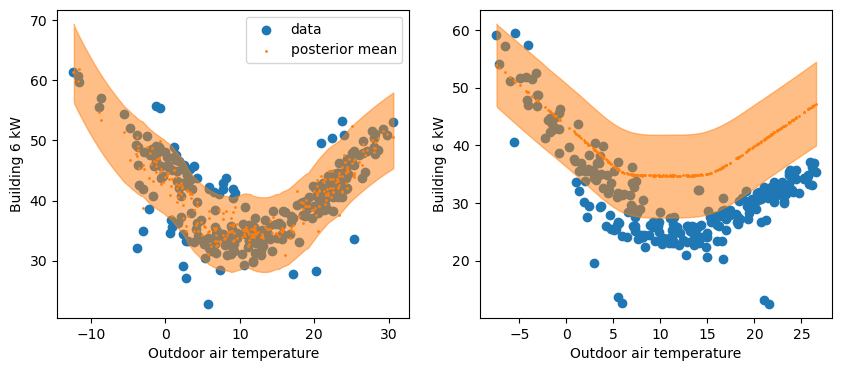

In [12]:
y_hat = idata.posterior_predictive["y_hat"]
y_hat_post = idata.posterior["y_hat_post"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(df_train['OAT'], df_train['Building 6 kW'], label="data")
ax[0].scatter(df_train['OAT'], y_hat.mean(("chain", "draw")), s=1, c="C1", label="posterior mean")
az.plot_hdi(df_train['OAT'], y_hat, ax=ax[0])
ax[0].set_xlabel('Outdoor air temperature')
ax[0].set_ylabel('Building 6 kW')
ax[0].legend()

ax[1].scatter(df_test['OAT'], df_test['Building 6 kW'])
ax[1].scatter(df_test['OAT'], y_hat_post.mean(("chain", "draw")), s=1, c="C1")
az.plot_hdi(df_test['OAT'], y_hat_post, ax=ax[1])
ax[1].set_xlabel('Outdoor air temperature')
ax[1].set_ylabel('Building 6 kW')

The left plot confirms a good fit between the training data and the predictions from the trained model. Most data points lie within the prediction intervals.

The right plot shows that the actual consumption during the reporting period is lower than predictions, which suggests that energy savings were made. The sum of the differences between predictions and consumption during this period are the total savings. They were formulated within the `generated quantities` of the Stan code, and we can therefore directly display their posterior distribution:

Let us now display the main result of the M&V workflow: estimated savings:

<Axes: title={'center': 'savings'}>

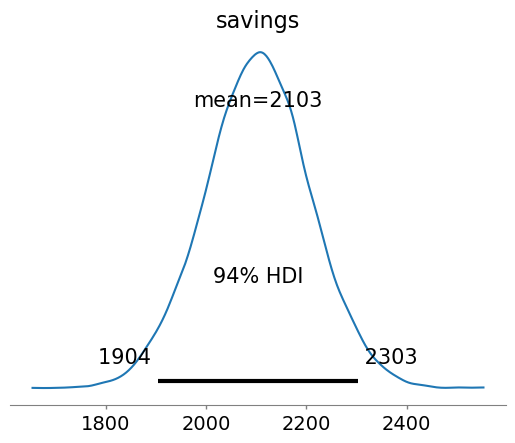

In [13]:
az.plot_posterior(idata, var_names='savings')

Compared to the results of the previous tutorial, the mean estimated savings are similar, but the uncertainty is slightly larger.

### Residuals

The whole point of this tutorial, compared to the previous one, is to reduce the autocorrelation of the prediction residuals, which would be a sign of a biased models and unreliable inferences. Have we succeded?

<Axes: title={'center': 'x\n0'}>

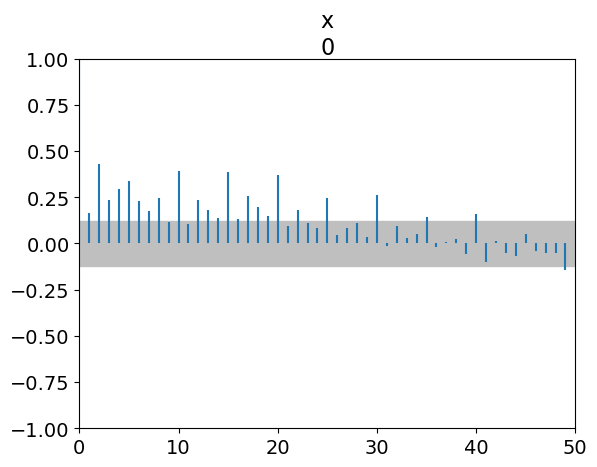

In [14]:
resid = df_train['Building 6 kW'] - y_hat.mean(("chain", "draw"))
az.plot_autocorr(resid.values, max_lag=50)

Every vertical line of this graph shows the correlation coefficient between the values of a series and its own values with a certain lag.

The lag-1 ACF has been significantly reduced. The cause for the correlation between consecutive residuals has not been solved, but the model now "knows" that something unexplained is causing it: predictions were made more uncertain as a way to aknowledge it. The estimated savings uncertainty can be considered more reliable.